
*   Name: Ishita Lyall
*   Roll no: 101903127
*   Group: 3COE15

*   Challenge: Predict the closing price of NASDAQ of the last trading day in 2021
*   Using LSTM and GRU RNN models to predcict NASDAQ price
*   Link of kaggle challenge: https://www.kaggle.com/c/110-1-ntut-dl-app-hw3/overview







In [ ]:
!nvidia-smi

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt

import cuml
import cupy as cp
import cudf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU  #Using RNN models
from keras.layers import Dropout

In [44]:
data_file = 'IXIC.csv'
df = pd.read_csv(data_file)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


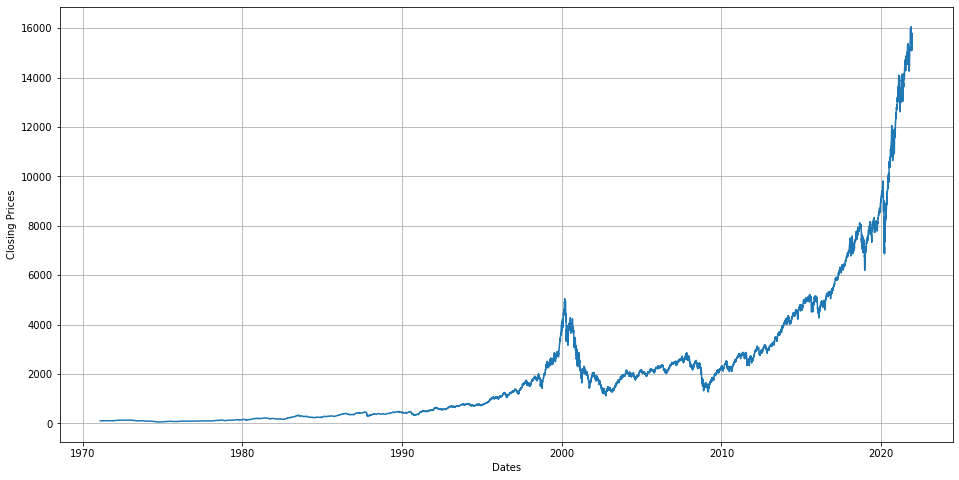

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv(data_file, sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
#data = data.loc['2012-11-10':'2017-11-10']
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data['Close']);

In [4]:
# Splitting the data into training and testing data
train_start_idx = -5000
train_end_idx = -500

print('Training data range: ', df.iloc[train_start_idx]['Date'], ' - ', df.iloc[train_end_idx]['Date'])

Training data range:  2002-01-31  -  2019-12-16


In [26]:
train_data = df[train_start_idx:train_end_idx].drop(columns=['Date']).to_numpy()
test_data = df[-500:].drop(columns=['Date']).to_numpy()
print(df.iloc[train_start_idx])
#Converting stock data into a numpy tensor

print(train_data[0])


Date          2002-01-31
Open         1924.560059
High         1935.170044
Low          1906.900024
Close        1934.030029
Adj Close    1934.030029
Volume        1803530000
Name: 7824, dtype: object
[1.92456006e+03 1.93517004e+03 1.90690002e+03 1.93403003e+03
 1.93403003e+03 1.80353000e+09]


In [6]:
# 1. Based on Keras Time Series Data Generator.
# 2. normalization: Use the beginning price of a sample price series to normalize data
# 3. target_index: The index of target value (label). The target is Adjusted closed price (index: -2) 

def generator(data, lookback, delay, min_index=0, max_index=None, shuffle=False, 
              batch_size=128, step=1, target_index=-2, normalize=True):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            if normalize:
                ## Normalization
                norm = data[rows[j] - lookback]
                samples[j] = data[indices] / norm
                targets[j] = data[rows[j] + delay][target_index] / norm[target_index]
            else:
                samples[j] = data[indices]
                targets[j] = data[rows[j] + delay][target_index]
        yield samples, targets

In [34]:
lookback = 20        # Using last 20 trading days as input data
step = 1
delay = 15           # Prdicting the price in 15 days(15 days after 8Dec,21 is 23Dec,21 which is the last trading day)
batch_size = 10 
target_idx = -2     # The 2nd last column (Adj Close) is our target prediction
num_val_data = 100  # Use 100 days as validation data 

train_gen = generator(train_data[0: ],
                      lookback=lookback,
                      delay=delay,
                      max_index= len(train_data) - num_val_data - 1,
                      step=step, 
                      normalize=True,
                      target_index = target_idx,
                      batch_size=batch_size)

val_gen = generator(train_data,
                      lookback=lookback,
                      delay=delay,
                      step=step, 
                      min_index= len(train_data) - num_val_data,
                      normalize=True,
                      target_index = target_idx,
                      batch_size=batch_size)
val_steps = (num_val_data - lookback) // batch_size

In [35]:
# Training samples

for samples, targets in train_gen:
    print(samples)
    print(targets)
    break

[[[1.         1.         1.         1.         1.         1.        ]
  [1.00221864 1.00360691 0.99701607 0.9882163  0.9882163  0.94814059]
  [0.99117715 0.98574281 0.96970475 0.95941118 0.95941118 0.98641553]
  ...
  [0.92360851 0.92433738 0.91790863 0.91356388 0.91356388 0.92625573]
  [0.9265962  0.92691078 0.91325185 0.90581841 0.90581841 1.01103946]
  [0.91414656 0.91630188 0.90652368 0.89527565 0.89527565 1.07324525]]

 [[1.         1.         1.         1.         1.         1.        ]
  [0.98898296 0.9822001  0.97260694 0.9708514  0.9708514  1.04036842]
  [0.95634143 0.96178973 0.96184539 0.96195142 0.96195142 1.23208772]
  ...
  [0.92454497 0.92357952 0.91598509 0.91661958 0.91661958 1.06633918]
  [0.91212289 0.91300874 0.90923678 0.90595111 0.90595111 1.13194737]
  [0.90494757 0.92829596 0.91630067 0.94323057 0.94323057 1.1125848 ]]

 [[1.         1.         1.         1.         1.         1.        ]
  [0.96699485 0.97921974 0.98893536 0.9908328  0.9908328  1.1842802 ]
  [0

In [36]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.GRU(16, input_shape=(None, train_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='RMSprop', loss='mae')
history = model.fit_generator(train_gen, 
                            steps_per_epoch=500, epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


500/500 [==============================] - 7s 10ms/step - loss: 0.0450 - val_loss: 0.0362
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0367 - val_loss: 0.0325
Epoch 3/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0395 - val_loss: 0.0387
Epoch 4/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0369 - val_loss: 0.0400
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0358 - val_loss: 0.0318
Epoch 6/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0369 - val_loss: 0.0329
Epoch 7/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0367 - val_loss: 0.0604
Epoch 8/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0383 - val_loss: 0.0502
Epoch 9/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0357 - val_loss: 0.0245
Epoch 10/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0395 - val_loss: 0.0204
Epoch 11

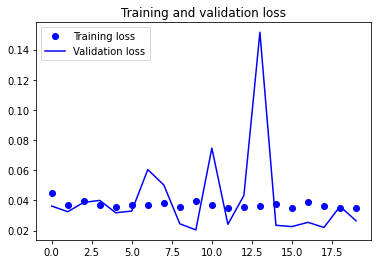

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
test_gen = generator(test_data,
                      lookback=lookback,
                      delay=delay,
                      step=step, 
                      normalize=True,
                      target_index = target_idx,
                      batch_size=batch_size)

In [39]:
model.evaluate_generator(test_gen, len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.055802520364522934

In [41]:
# Predicting the price after 15 days
prices = df.iloc[-lookback:].drop(columns=['Date']).to_numpy()
x = prices / prices[0]
price_sample = np.expand_dims(x, axis=0)
pred = model.predict(price_sample)

pred_price = pred[0][0]*prices[0][target_idx]

print('The NASDAQ price for', str(delay) ,'trading days after ', df.iloc[-1]['Date'], ' is ' + str(pred_price))

The NASDAQ price for 15 trading days after  2021-12-08  is 15802.35065435677


expected value: 16000,  predicted value: 15802.35065435677